In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

import sklearn
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from joblib import dump, load

import spacy

In [2]:
data = pd.read_csv("cyai.tsv", sep="\t")

In [3]:
nlp = spacy.load("en_core_web_lg")

In [4]:
docs = []
for doc in nlp.pipe(data.description):
    docs.append(" ".join(word.lemma_ for word in doc if not word.is_stop and not word.is_punct))

In [11]:
logistic_hyperparams = {
    "solver": ["liblinear"],
    "C": [0.25, 0.5, 1, 2, 4],
    "penalty": ["l1", "l2"]
}

adaboost_hyperparams = {
    'n_estimators': [8, 32, 128, 512],
    'learning_rate': [0.125, 0.25, 0.5, 1],
}

gradboost_hyperparams = {
    'loss' : ['deviance', 'exponential'],
    'n_estimators': [8, 32, 128, 512],
    'max_depth': [1, 2 , 4, 8]
}

randomforest_hyperparams = {
    'n_estimators': [8, 32, 128, 512],
    'max_depth': [1, 2, 4, 8]
}

decisiontree_hyperparams = {
    "criterion": ["gini", "entropy"],
    "splitter": ["best", "random"],
    "max_depth": [1, 2 , 4, 8],
}

mlp_hyperparams = {
    "activation": ["tanh", "relu"],
    "alpha": [1e-3, 1e-4, 1e-5],
    "max_iter": [32,128,512],
    "learning_rate": ["constant", "adaptive"],
}

svc_hyperparams = {
    "probability": [True],
}

In [6]:
models_hyperparams = [
    logistic_hyperparams,
    adaboost_hyperparams,
    gradboost_hyperparams,
    randomforest_hyperparams,
    decisiontree_hyperparams,
    mlp_hyperparams,
    svc_hyperparams,
]

models = [
    LogisticRegression,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    DecisionTreeClassifier,
    MLPClassifier,
    SVC,
]

In [7]:
best_gridsearch = None

In [9]:
n_folds = 4
n_jobs = 7

for Model, hyperparams in zip(models, models_hyperparams):
    parameters = {
        'vect__max_df': (0.75, 1.0),
        'vect__min_df': (2,0.1),
        'vect__max_features': (None, 1024),
        'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
        'tfidf__use_idf': (True, False),
        'tfidf__norm': ('l1', 'l2'),
    }
    for h in hyperparams:
        parameters["clf__{}".format(h)] = hyperparams[h]
    
    pipeline = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', Model()),
    ])
    grid_search = GridSearchCV(pipeline,
                               parameters,
                               scoring="roc_auc",
                               cv=StratifiedKFold(n_folds, shuffle=True),
                               n_jobs=n_jobs,
                               verbose=1)

    grid_search.fit(docs, data.is_ethics)
    print(type(grid_search.best_estimator_.named_steps["clf"]).__name__, grid_search.best_score_)
    
    if best_gridsearch is None or grid_search.best_score_ > best_gridsearch.best_score_:
        best_gridsearch = grid_search

Fitting 4 folds for each of 640 candidates, totalling 2560 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    3.6s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:    7.0s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:   12.6s
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:   22.0s
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:   34.4s
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:   47.1s
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  1.1min
[Parallel(n_jobs=7)]: Done 2560 out of 2560 | elapsed:  1.1min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


LogisticRegression 0.7870843233343233
Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    1.8s
[Parallel(n_jobs=7)]: Done 358 tasks      | elapsed:   11.6s
[Parallel(n_jobs=7)]: Done 710 tasks      | elapsed:   33.9s
[Parallel(n_jobs=7)]: Done 1060 tasks      | elapsed:  1.8min
[Parallel(n_jobs=7)]: Done 1510 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 2060 tasks      | elapsed:  3.5min
[Parallel(n_jobs=7)]: Done 2710 tasks      | elapsed:  4.0min
[Parallel(n_jobs=7)]: Done 3460 tasks      | elapsed:  5.5min
[Parallel(n_jobs=7)]: Done 4096 out of 4096 | elapsed:  7.1min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


AdaBoostClassifier 0.7862007887007887
Fitting 4 folds for each of 2048 candidates, totalling 8192 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=7)]: Done 358 tasks      | elapsed:   10.3s
[Parallel(n_jobs=7)]: Done 829 tasks      | elapsed:   39.8s
[Parallel(n_jobs=7)]: Done 1179 tasks      | elapsed:  1.2min
[Parallel(n_jobs=7)]: Done 1629 tasks      | elapsed:  1.6min
[Parallel(n_jobs=7)]: Done 2179 tasks      | elapsed:  2.8min
[Parallel(n_jobs=7)]: Done 2829 tasks      | elapsed:  3.7min
[Parallel(n_jobs=7)]: Done 3579 tasks      | elapsed:  5.1min
[Parallel(n_jobs=7)]: Done 4429 tasks      | elapsed:  6.6min
[Parallel(n_jobs=7)]: Done 5379 tasks      | elapsed:  7.6min
[Parallel(n_jobs=7)]: Done 6429 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done 7579 tasks      | elapsed: 11.5min
[Parallel(n_jobs=7)]: Done 8192 out of 8192 | elapsed: 13.3min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The defau

GradientBoostingClassifier 0.7591310266310266
Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    1.6s
[Parallel(n_jobs=7)]: Done 358 tasks      | elapsed:    9.7s
[Parallel(n_jobs=7)]: Done 831 tasks      | elapsed:   34.5s
[Parallel(n_jobs=7)]: Done 1181 tasks      | elapsed:  1.0min
[Parallel(n_jobs=7)]: Done 1631 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 2181 tasks      | elapsed:  2.0min
[Parallel(n_jobs=7)]: Done 2831 tasks      | elapsed:  2.5min
[Parallel(n_jobs=7)]: Done 3581 tasks      | elapsed:  3.4min
[Parallel(n_jobs=7)]: Done 4096 out of 4096 | elapsed:  4.3min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier 0.8417492079992079
Fitting 4 folds for each of 1024 candidates, totalling 4096 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed:    1.5s
[Parallel(n_jobs=7)]: Done 358 tasks      | elapsed:    8.8s
[Parallel(n_jobs=7)]: Done 858 tasks      | elapsed:   20.5s
[Parallel(n_jobs=7)]: Done 1558 tasks      | elapsed:   36.9s
[Parallel(n_jobs=7)]: Done 2458 tasks      | elapsed:   58.0s
[Parallel(n_jobs=7)]: Done 3558 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 4096 out of 4096 | elapsed:  1.6min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


DecisionTreeClassifier 0.7316644804144804
Fitting 4 folds for each of 2304 candidates, totalling 9216 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    3.7s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   17.3s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.4min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  5.2min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  6.8min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 10.8min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed: 15.8min
[Parallel(n_jobs=7)]: Done 3186 tasks      | elapsed: 20.9min
[Parallel(n_jobs=7)]: Done 4036 tasks      | elapsed: 25.9min
[Parallel(n_jobs=7)]: Done 4986 tasks      | elapsed: 31.7min
[Parallel(n_jobs=7)]: Done 6036 tasks      | elapsed: 40.2min
[Parallel(n_jobs=7)]: Done 7186 tasks      | elapsed: 46.8min
[Parallel(n_jobs=7)]: Done 8436 tasks      | elapsed: 56.5min
[Parallel(n_jobs=7)]: Done 9216 out of 9216 | elapsed: 61.7min finished
C:\Users\Pedro\Anaconda3\lib\site-packages\sklearn\

MLPClassifier 0.787819069069069
Fitting 4 folds for each of 192 candidates, totalling 768 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


ValueError: Invalid parameter penalty for estimator SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False). Check the list of available parameters with `estimator.get_params().keys()`.

In [10]:
best_gridsearch.best_params_

{'clf__max_depth': 8,
 'clf__n_estimators': 512,
 'tfidf__norm': 'l1',
 'tfidf__use_idf': False,
 'vect__max_df': 0.75,
 'vect__max_features': None,
 'vect__min_df': 2,
 'vect__ngram_range': (1, 1)}

In [14]:
best_gridsearch.best_estimator_.named_steps["clf"]

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=512, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [15]:
pipeline = Pipeline([
        ('vect', CountVectorizer(
            max_df = 0.75,
            max_features = None,
            min_df = 2,
        )),
        ('tfidf', TfidfTransformer(
            norm = "l1",
            use_idf = False,
        )),
        ('clf', RandomForestClassifier(
            max_depth = 8,
            n_estimators = 512,
        )),
    ])

In [16]:
pipeline.fit(docs,data.is_ethics)

Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.75, max_features=None, min_df=2,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        stri...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

In [21]:
y_pred = pipeline.predict(docs)
y_prob = pipeline.predict_proba(docs)

In [22]:
for metric, name in zip(
        [confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score],
        ["confusion_matrix", "f1_score", "precision_score", "recall_score", "accuracy_score", "roc_auc_score"]
        ):
    print(name, metric(data.is_ethics, y_pred))

confusion_matrix [[146   0]
 [ 19  35]]
f1_score 0.7865168539325843
precision_score 1.0
recall_score 0.6481481481481481
accuracy_score 0.905
roc_auc_score 0.8240740740740741


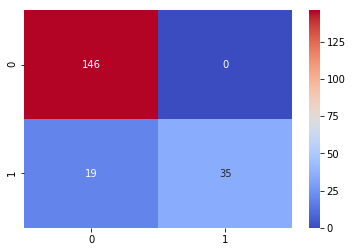

In [34]:
sns.heatmap(confusion_matrix(data.is_ethics, y_pred), annot=True, fmt="d", cmap="coolwarm")

In [46]:
confidence_margin = 0.35

print(sum(np.logical_or(y_prob[:,1]<confidence_margin, y_prob[:,1]>1-confidence_margin)))
print(sum(y_prob[:,1]>1-confidence_margin))

152
4


In [50]:
dump(pipeline, "pipeline.joblib")

['pipeline.joblib']